# Setup and Load Data

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [6]:
from pathlib import Path
import pandas as pd
import fastai
import torch
fastai.__version__, torch.__version__

('1.0.57', '1.0.1.post2')

In [7]:
data_path = Path('./data')
data_path.absolute(), data_path.exists()

(PosixPath('/home/intsco/Dropbox/ML/off_sample/classification/data'), True)

In [9]:
rows = []
for ds_path in (data_path / 'GS').iterdir():
    for ds_class_path in ds_path.iterdir():
        image_class = ds_class_path.name
        for image_path in ds_class_path.iterdir():
            rows.append((image_path, image_class))

In [15]:
path_label_df = pd.DataFrame(rows, columns=['path', 'label'])
path_label_df.shape

(23238, 2)

In [16]:
path_label_df.head()

,path,label
0,data/GS/Dataset 30/off/C18H30O+H.png,off
1,data/GS/Dataset 30/off/C21H30O5+H.png,off
2,data/GS/Dataset 30/off/C14H18O3+K.png,off
3,data/GS/Dataset 30/off/C28H22O3+K.png,off
4,data/GS/Dataset 30/off/C18H17NO6+K.png,off


In [17]:
# path_label_df = pd.read_csv(data_path / 'path_label.csv')
# path_label_df.head()

In [18]:
labels = (path_label_df.label == 'off').astype(int).values

In [19]:
pd.value_counts(labels)

0    13329
1     9909
dtype: int64

# Predict from Dataframe

In [23]:
import sklearn
from pathlib import Path

In [24]:
from fastai.vision.data import ImageList

In [25]:
from fastai import *
from fastai.vision import *

In [26]:
%%time
export_fn = 'models/resnet-50.fai'
learn = load_learner('.', export_fn)

CPU times: user 66 ms, sys: 69.2 ms, total: 135 ms
Wall time: 165 ms


/opt/dev/miniconda3/envs/fastai-cpu/lib/python3.6/site-packages/torch/serialization.py:435: SourceChangeWarning: source code of class 'torchvision.models.resnet.Bottleneck' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)
/opt/dev/miniconda3/envs/fastai-cpu/lib/python3.6/site-packages/torch/serialization.py:435: SourceChangeWarning: source code of class 'fastai.layers.AdaptiveConcatPool2d' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)
/opt/dev/miniconda3/envs/fastai-cpu/lib/python3.6/site-packages/torch/serialization.py:435: SourceChangeWarning: source code of class 'fastai.layers.Flatten' has changed. you can retrieve the or

In [27]:
image_list = ImageList.from_df(path_label_df, '.')
image_list

ImageList (23238 items)
Image (3, 92, 132),Image (3, 92, 132),Image (3, 92, 132),Image (3, 92, 132),Image (3, 92, 132)
Path: .

In [28]:
%%time
# test_item_list = ImageList.from_folder(test_input_path)
learn.data.add_test(image_list)

pred_probs, _ = learn.get_preds(DatasetType.Test)
pred_probs = pred_probs.numpy()

CPU times: user 3h 11min 53s, sys: 52min 58s, total: 4h 4min 52s
Wall time: 20min 28s


In [29]:
pred_probs.shape

(23238, 2)

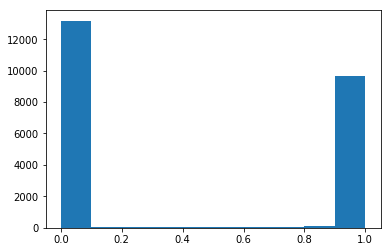

In [30]:
plt.hist(pred_probs[:,0]);

In [31]:
target_class_idx = learn.data.classes.index('off')
target_class_idx

0

In [32]:
preds = (pred_probs[:, target_class_idx] > 0.5).astype(int)
preds

array([1, 1, 1, 1, ..., 0, 0, 0, 0])

**Calculate accuracy**

In [33]:
(preds == labels).mean()

0.9934589895860229

### Save Predictions

In [81]:
import shutil

In [82]:
pred_path = (data_path / 'GS_predictions')
pred_path.mkdir(exist_ok=True)

In [83]:
pred_rows = []
for t in path_label_df.itertuples():
    off_prob = pred_probs[t.Index, target_class_idx]
    pred_label = 'off' if off_prob > 0.5 else 'on'

    dataset = t.path.parent.parent.name
    image_fn = t.path.name
    image_path = t.path

    pred_image_path = pred_path / dataset / pred_label / image_fn
    pred_image_path.parent.mkdir(parents=True, exist_ok=True)
    shutil.copy(image_path, pred_image_path)

    pred_rows.append((pred_image_path, pred_label, off_prob))

In [86]:
pred_df = pd.DataFrame(pred_rows, columns=['path', 'pred_label', 'off_sample_pred_prob'])
pred_df.shape

(23238, 3)

In [87]:
pred_df.head()

,path,pred_label,off_sample_pred_prob
0,data/GS_predictions/Dataset 30/off/C18H30O+H.png,off,0.995310
1,data/GS_predictions/Dataset 30/off/C21H30O5+H.png,off,0.999994
2,data/GS_predictions/Dataset 30/off/C14H18O3+K.png,off,0.999977
3,data/GS_predictions/Dataset 30/off/C28H22O3+K.png,off,0.999999
4,data/GS_predictions/Dataset 30/off/C18H17NO6+K...,off,0.999997


In [88]:
pred_df[pred_df.pred_label == 'on'].head()

,path,pred_label,off_sample_pred_prob
171,data/GS_predictions/Dataset 30/on/C32H50O7+H.png,on,0.000297
172,data/GS_predictions/Dataset 30/on/C33H56O14+K.png,on,0.000085
173,data/GS_predictions/Dataset 30/on/C24H40O4+Na.png,on,0.000060
174,data/GS_predictions/Dataset 30/on/C51H97O8P+Na...,on,0.000417
175,data/GS_predictions/Dataset 30/on/C22H30Cl2N10...,on,0.007000


In [91]:
pred_df.to_csv(data_path / 'gs_predictions.tsv', index=False, sep='\t')

# Test Off Sample API

In [137]:
from requests import post
import json
import base64
from pathlib import Path
import shutil
from PIL import Image
import io

In [138]:
image_paths = path_label_df.path.values
len(image_paths)

1660

In [175]:
# chunk_size = 32
# chunk_n = len(image_paths) // chunk_size + 1
# image_path_chunks = [image_paths[i*chunk_size:(i+1)*chunk_size] for i in range(chunk_n)]

In [176]:
def make_chunk_gen(items, chunk_size):
    chunk_n = (len(items) - 1) // chunk_size + 1
    chunks = [items[i * chunk_size:(i + 1) * chunk_size] for i in range(chunk_n)]
    for image_path_chunk in chunks:
        yield image_path_chunk

In [140]:
len([len(ch) for ch in image_path_chunks])

52

In [182]:
import threading
from functools import wraps
from time import sleep

# api_url = 'http://EC2Co-EcsEl-YRBQ515NL1PR-1223156817.eu-west-1.elb.amazonaws.com/off-sample/predict'
# api_endpoint = 'http://localhost:9876/off-sample'
api_endpoint = 'http://off-sample-api-load-balancer-630496755.eu-west-1.elb.amazonaws.com/off-sample'

def retry_on_error(num_retries=3):
    def decorator(func):
        @wraps(func)
        def wrapper(*args, **kwargs):
            for i in range(num_retries):
                try:
                    return func(*args, **kwargs)
                except Exception:
                    delay = random.uniform(2, 2**(i + 2))
                    thread_name = threading.currentThread().getName()
                    print((f'[{thread_name}] Off-sample API error on attempt {i + 1}. '
                           f'Retrying after {delay:.1f} seconds...'))
                    sleep(delay)
            # Last attempt, don't catch the exception
            return func(*args, **kwargs)

        return wrapper

    return decorator

@retry_on_error()
def predict_chunk(image_path_chunk):
    base64_images = []
    for fp in image_path_chunk:
        with open(fp, 'rb') as f:
            content = base64.b64encode(f.read()).decode()
            base64_images.append(content)
    doc = {
        'images': [{'content': content} for content in base64_images]
    }
    
    resp = post(url=api_endpoint + '/predict', json=doc)
    if resp.status_code == 200:
        chunk_preds = resp.json()['predictions']
    else:
        raise Exception(resp)
    return chunk_preds

#### Test API Synchronously 

In [81]:
# predict_chunk(image_path_chunks[0])

In [85]:
# %%time
# predictions = []
# for image_path_chunk in image_path_chunks:
#     chunk_preds = predict_chunk(image_path_chunk)
#     predictions.extend(chunk_preds)

In [83]:
len(predictions)

64

In [84]:
predictions[:5]

[{'prob': 0.9252671599388123, 'label': 'off'},
 {'prob': 0.9698059558868408, 'label': 'off'},
 {'prob': 0.9950131773948669, 'label': 'off'},
 {'prob': 0.9864990711212158, 'label': 'off'},
 {'prob': 0.001479876460507512, 'label': 'on'}]

#### Test API Asynchronously

In [183]:
from concurrent.futures import ThreadPoolExecutor, ProcessPoolExecutor

In [185]:
%%time
predictions = []
with ThreadPoolExecutor(2) as pool:
    for ch_preds in pool.map(predict_chunk, image_path_chunks):
        predictions.extend(ch_preds)

CPU times: user 385 ms, sys: 44.9 ms, total: 430 ms
Wall time: 8min 43s


In [147]:
len(predictions)

1660

In [148]:
preds = [p['prob'] > 0.5 for p in predictions]

**Test set accuracy**

In [149]:
(preds == labels).mean()

0.9590361445783132